In [1]:
import mysql.connector as sql
import pandas as pd
import datetime as dt
import numpy as np
from sorted_months_weekdays import *
from sort_dataframeby_monthorweek import *
import matplotlib.pyplot as plt
import math
import json
from pandas.io.json import json_normalize
import requests
import matplotlib.dates as mdates
from datetime import date, timedelta

In [2]:
db_connection = sql.connect(host='localhost', database='collection_visits', user='pandas', password='password')

pensActivity = pd.read_sql('SELECT * FROM PensActivity', con=db_connection)
pensActivity['created'] = pd.to_datetime(pensActivity['created'], unit='s')
pensActivity['lastmodified'] = pd.to_datetime(pensActivity['lastmodified'], unit='s')
pensActivity['created'].replace(0, np.nan, inplace=True)
pensActivity['lastmodified'].replace(0, np.nan, inplace=True)
pensActivity['notes'].replace(r'^\s*$', np.NaN, regex=True, inplace=True)
pensActivity['notes'] = pensActivity['notes'].astype('category')
pensActivity.sort_values(by='created', inplace=True)

pensCheckouts = pd.read_sql('SELECT * FROM PensCheckouts', con=db_connection)
pensCheckouts['start'] = pd.to_datetime(pensCheckouts['start'], unit='s')
pensCheckouts['start'].replace(0, np.nan, inplace=True)
pensCheckouts['end'].replace(0, np.nan, inplace=True)
pensCheckouts['end'] = pd.to_datetime(pensCheckouts['end'], unit='s')
pensCheckouts['start_ip'].replace(0, np.nan, inplace=True)
pensCheckouts['end_ip'].replace(0, np.nan, inplace=True)
pensCheckouts['start_ip'] = pensCheckouts['start_ip'].astype('category')
pensCheckouts['end_ip'] = pensCheckouts['end_ip'].astype('category')
pensCheckouts.set_index('id', inplace=True)
pensCheckouts.sort_index(inplace=True)
###DROPED COLUMNS####
pensCheckouts.drop(['start_ip', 'end_ip'], axis=1, inplace=True)

In [67]:
pensCheckouts.set_index(['visit_id'], inplace=True)

In [68]:
pensActivity.set_index(['visit_id'], inplace=True)

In [69]:
checkout_activity = pensCheckouts.join(pensActivity, how='left', lsuffix='_checkout', rsuffix='_activity')

In [70]:
checkout_activity

,pen_id_checkout,start,end,pen_id_activity,fingerprint,activity,notes,status_id,created,lastmodified,time_to_process,count_items
visit_id,,,,,,,,,,,,
793401,8,2014-10-23 15:36:51,2014-10-25 00:44:42,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN
793449,3,2014-10-23 16:25:42,2014-10-25 00:44:42,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN
793527,9,2014-10-24 02:04:59,2014-10-25 00:44:42,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN
793571,2,2014-10-24 15:05:23,2014-10-27 17:53:29,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN
793681,7,2014-10-25 00:02:19,2014-10-27 17:53:29,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
132777683,1520099,2020-07-02 20:22:28,2020-07-02 20:22:44,1524473.0,8de20189e64f86c4f892b98ca7d30077b00b3874,"{""ticket_id"":""tzctj"",""registers"":""None"",""colle...",NaN,1.0,2020-07-02 20:22:39,2020-07-02 20:22:39,161.0,1.0
132794701,1520099,2020-07-06 17:42:18,2020-07-06 17:43:00,1524473.0,c24003e782909cd4a8385fd84970943237aa605b,"{""ticket_id"":""gz65"",""registers"":""None"",""collec...",NaN,1.0,2020-07-06 17:42:37,2020-07-06 17:42:37,159.0,1.0
132806719,1520099,2020-07-09 13:12:28,2020-07-09 13:12:46,1524473.0,513e424fc16895f97ae6e70e9bb74f9a58c59229,"{""ticket_id"":""56bs6"",""registers"":""None"",""colle...",NaN,1.0,2020-07-09 13:12:38,2020-07-09 13:12:38,172.0,1.0


In [75]:
checkout_activity_na = checkout_activity[checkout_activity['pen_id_activity'].isna()]

In [83]:
checkout_activity_na['pen_id_checkout'].count()

149417

In [88]:
checkout_activity_na_yealry = checkout_activity_na['start'].groupby(checkout_activity_na.start.dt.to_period('Y')).agg('count')
checkout_activity_na_yealry

start
2014      177
2015    30074
2016    27851
2017    24293
2018    35602
2019    25781
2020     5639
Freq: A-DEC, Name: start, dtype: int64

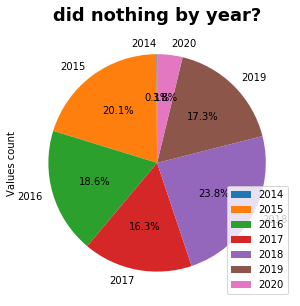

In [91]:
checkout_activity_na_yealry.plot.pie(y='start', figsize=(5, 5),autopct='%1.1f%%', startangle=90)
plt.title('did nothing by year?', fontdict={'fontweight': 'bold', 'fontsize':18})
plt.ylabel('Values count')
plt.legend()

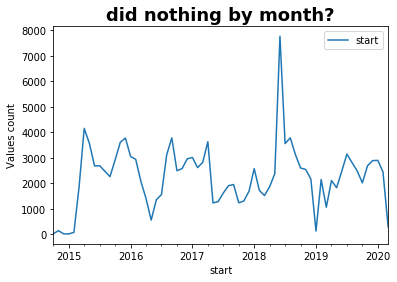

In [94]:
checkout_activity_na_month = checkout_activity_na['start'].groupby(checkout_activity_na.start.dt.to_period('M')).agg('count')

checkout_activity_na_month.plot()
plt.title('did nothing by month?', fontdict={'fontweight': 'bold', 'fontsize':18})
plt.ylabel('Values count')
plt.legend()

In [93]:
checkout_activity_na_month.nlargest()

start
2018-06    7770
2015-04    4154
2018-08    3786
2016-09    3782
2015-12    3776
Freq: M, Name: start, dtype: int64